In [1]:
import numpy as np
import pandas as pd
import folium
from folium import plugins
from folium.plugins import HeatMap
import calplot as cp
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import plotly
import os
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
from sklearn.linear_model import Ridge
from urllib.request import urlopen
import json
import scipy.stats as stats

In [2]:
pd.options.mode.chained_assignment = None

# Load data
data = pd.read_csv("Police_Department_Incident_Reports__Historical_2003_to_May_2018_20250204.csv")
data2 = pd.read_csv("Police_Department_Incident_Reports__2018_to_Present_20250210.csv")

# Keep only relevant columns
updatedData = data[["Category", "Descript", "DayOfWeek", "Date", "Time", "PdDistrict", "Resolution", "X", "Y", "location"]]

updatedData2 = data2[["Incident Category", "Incident Description", "Incident Day of Week", "Incident Datetime", "Incident Time", "Police District", "Resolution", "Longitude", "Latitude", "Point"]]

# Rename columns in updatedData2 to match updatedData
updatedData2.rename(columns={'Incident Category': 'Category',
                             'Incident Description': 'Descript',
                             'Incident Day of Week': 'DayOfWeek',
                             'Incident Datetime': 'Date',
                             'Incident Time': 'Time',
                             'Police District': 'PdDistrict',
                             'Longitude': 'X',
                             'Latitude': 'Y',
                             'Point': 'location'}, inplace=True)

# Convert date to datetime format
updatedData["Date"] = pd.to_datetime(updatedData["Date"])
updatedData2["Date"] = pd.to_datetime(updatedData2["Date"])

# Combine datasets
combinedData = pd.concat([updatedData, updatedData2])

# Uppercase all category & district values
combinedData["Category"] = combinedData["Category"].map(lambda x: x.upper() if isinstance(x, str) else x)
combinedData["PdDistrict"] = combinedData["PdDistrict"].map(lambda x: x.upper() if isinstance(x, str) else x)

# Standardize category names
combinedData.loc[combinedData["Category"].isin(["WEAPONS CARRYING ETC", "WEAPONS OFFENCE", "WEAPONS OFFENSE", "WEAPONS LAWS"]), "Category"] = "WEAPON LAWS"

combinedData.loc[combinedData["Category"] == "WARRANTS", "Category"] = "WARRANT"

combinedData.loc[combinedData["Category"].isin(["DRUG VIOLATION", "DRUG OFFENSE"]), "Category"] = "DRUG/NARCOTIC"

combinedData.loc[combinedData["Category"].isin(["MOTOR VEHICLE THEFT", "MOTOR VEHICLE THEFT?"]), "Category"] = "VEHICLE THEFT"

combinedData.loc[combinedData["Category"] == "LARCENY THEFT", "Category"] = "LARCENY/THEFT"

# Assignment 2: Assault crime in San Fransisco
In this assignment we are looking at San Fransisco crime data over the years 2003-2025. The data is from DataSF, a citywide government project providing open source data pertaining to the city. The data was originally split into two datasets, [2003-2018](https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-Historical-2003/tmnf-yvry/about_data) and [2018-present](https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-2018-to-Present/wg3w-h783/about_data) which we combined and pre-prossesed, ensuring cohesiveness of the data. For our analysis we chose to focus on assault crime data as we found this to have some interesting insights and a rather large amount of data.

## Assault crime occurences in San Fransisco over time
To start, we will be looking at assault crime occurences in San Fransisco over the years. To more easily see if any temporal trends appear, we will be making a calendar plot. This allows us to easily find patterns in the data.

(<Figure size 1250x3910 with 24 Axes>,
 array([<Axes: ylabel='2003'>, <Axes: ylabel='2004'>,
        <Axes: ylabel='2005'>, <Axes: ylabel='2006'>,
        <Axes: ylabel='2007'>, <Axes: ylabel='2008'>,
        <Axes: ylabel='2009'>, <Axes: ylabel='2010'>,
        <Axes: ylabel='2011'>, <Axes: ylabel='2012'>,
        <Axes: ylabel='2013'>, <Axes: ylabel='2014'>,
        <Axes: ylabel='2015'>, <Axes: ylabel='2016'>,
        <Axes: ylabel='2017'>, <Axes: ylabel='2018'>,
        <Axes: ylabel='2019'>, <Axes: ylabel='2020'>,
        <Axes: ylabel='2021'>, <Axes: ylabel='2022'>,
        <Axes: ylabel='2023'>, <Axes: ylabel='2024'>,
        <Axes: ylabel='2025'>], dtype=object))

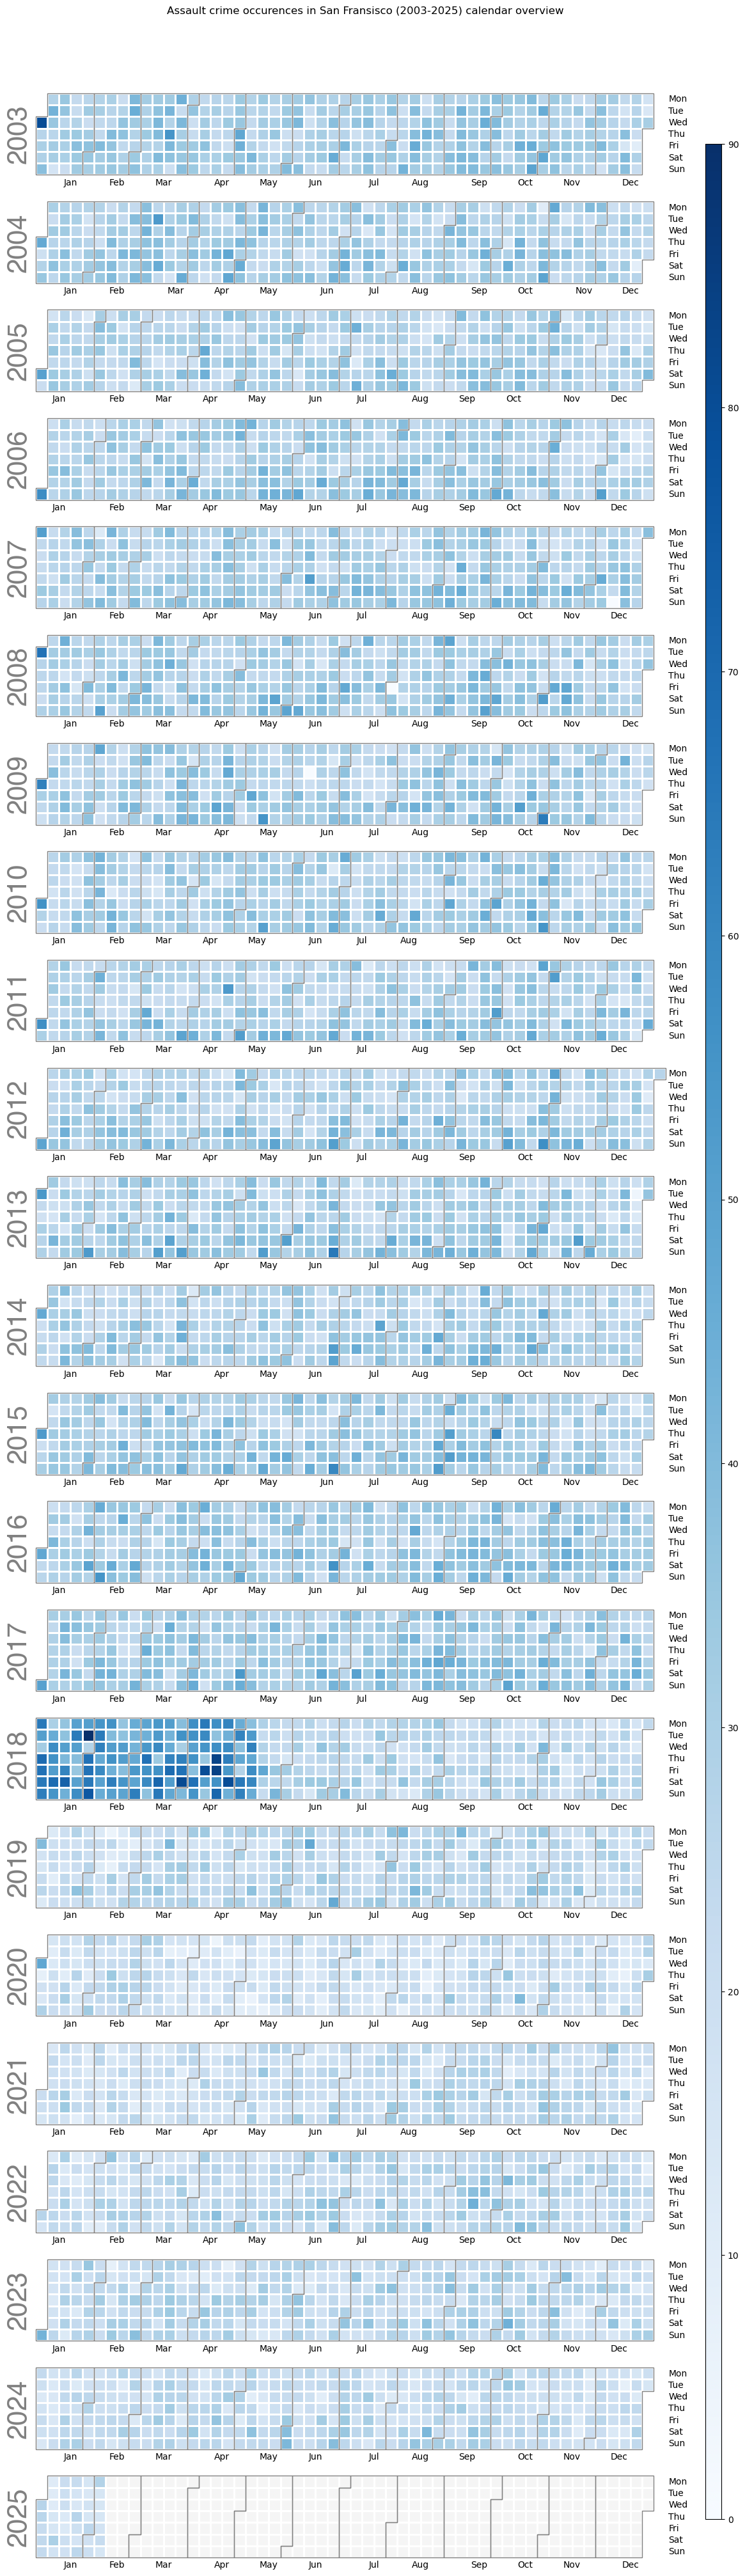

In [4]:
# Visualization 1: time-series

assaultDf = combinedData[combinedData['Category'] == 'ASSAULT']

# Ensure Date column is in datetime format
assaultDf["Date"] = pd.to_datetime(assaultDf["Date"])

# Add a Year column
assaultDf["Year"] = assaultDf["Date"].dt.year  

# Filter dataset for specific crime category
df_specific = assaultDf[assaultDf["Category"] == "ASSAULT"]

# Group by Date to count crimes per day
daily_counts = df_specific.groupby(df_specific["Date"]).size()

# Plot the calendar heatmap
calplotSfAssault = cp.calplot(daily_counts, cmap="Blues", suptitle='Assault crime occurences in San Fransisco (2003-2025) calendar overview', colorbar=True)
calplotSfAssault

When we take a look at the time series data for assault specificly, we see a few interesting trends.

Firstly, in the vast majority of the years, January 1st appears to have a high count of assault crimes compared to the remainder of the year. We could speculate that this is due to New Years celebrations, but interestingly December 31st does not seem to be particularly high in assault charges, meaning they are kept to after the new year has arrived. Another big celebration day in the US is 4th of July, however, that one doesn't seem to have as strong a trend of assault crimes. This may speak to a difference in the type of celebration; the 4th of July is more often celebrated with family and is held earlier in the day compared to New Years celebrations. Another holiday that is perhaps a bit more similar in its celebrations compared to New Years, at least for young adults and particularly college students, is Halloween on the 31st of October; here we do see a spike in assault crimes on the 31st of October and 1st of November some years, however, still not as consistently as the New Years celebrations.

Another very peculiar trend we are seeing, is the first 4.5 months of 2018; here we consistently see a significantly higher amount of assault crimes compared to both the rest of the year and the other years as well. While many events happened that year, from an [earthquake on January 4th](https://eu.usatoday.com/story/news/nation/2018/01/04/earthquake-shakes-san-francisco-area/1002768001/) to [cannabis becoming legal](https://abc7news.com/year-in-review-2018-abc7-top-stories-news-of-the/4939013/), none of these events seem to warrant the huge spike in assault crimes. We were furthermore unable to find any information on a possible police effort or increased police presence. This leads us to suspect there may be an error in or processing of the data; since 2018 was the cutoff year for the two crime data sets, perhaps there is a possibility some crimes have been double counted? However, checking our data (as seen below), there does not seem to be enough supposedly duplicate data (45 rows have been flagged as such). As such, it is diifuclt for us to determine what the cause of this spike is.

Finally, we see that in general, the number of assault crime occurences seem to be dwindeling as the years progresses. This consistent with what we saw for prostitution crimes in the previous assignment. This may either be due to a genuine decrease in such crimes over the years possibly due to it becoming more difficult to do so or more socially taboo (although we would think assault generally has been seen as the same amount of taboo in recent time), or, it can be due to less policing or less reporting from civilians, the latter potentially due to less trust in the police. With our current data, it is difficult to say which of these it may be, but it is clear that something has been happening incrementially over the years.

In [5]:
#checking crimes in January-April 2018
assaultJan2018Df = assaultDf[(assaultDf['Year'] == 2018)]
assaultJan2018Df = assaultJan2018Df[(assaultJan2018Df['Date'].dt.month == 1)
| (assaultJan2018Df['Date'].dt.month == 2)
| (assaultJan2018Df['Date'].dt.month == 3)
| (assaultJan2018Df['Date'].dt.month == 4)]

duplicatedCrimes = assaultJan2018Df[assaultJan2018Df.duplicated()].sort_values(['Date'], ascending=[True])
print("number of supposed duplicates: " + str(duplicatedCrimes.shape[0]))
duplicatedCrimes

number of supposed duplicates: 45


,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,X,Y,location,Year
772517,ASSAULT,"Assault, Aggravated, W/ Gun",Monday,2018-01-01 05:20:00,05:20,SOUTHERN,Cite or Arrest Adult,-122.396705,37.785542,POINT (-122.39670517825668 37.78554213006711),2018
631494,ASSAULT,Battery,Wednesday,2018-01-03 17:39:00,17:39,CENTRAL,Open or Active,-122.410456,37.798373,POINT (-122.41045615906502 37.79837270269259),2018
1444045,ASSAULT,AGGRAVATED ASSAULT WITH A KNIFE,Wednesday,2018-01-10 00:00:00,23:30,RICHMOND,NONE,-122.455389,37.781315,POINT (-122.45538919797396 37.78131511995256),2018
566508,ASSAULT,"Assault, Aggravated, W/ Other Weapon",Wednesday,2018-01-10 14:50:00,14:50,TENDERLOIN,Cite or Arrest Adult,-122.413676,37.780927,POINT (-122.41367636179726 37.780926854425914),2018
616618,ASSAULT,"Assault, Aggravated, W/ Other Weapon",Thursday,2018-01-11 09:54:00,09:54,SOUTHERN,Open or Active,-122.399802,37.781498,POINT (-122.39980220366621 37.7814979983372),2018
569799,ASSAULT,"Assault, Att. Homicide, W/ Gun",Saturday,2018-01-13 01:01:00,01:01,BAYVIEW,Open or Active,-122.395763,37.755621,POINT (-122.3957626269508 37.75562144550937),2018
675611,ASSAULT,Battery,Saturday,2018-01-13 18:30:00,18:30,SOUTHERN,Open or Active,-122.398503,37.771717,POINT (-122.39850261575857 37.7717172446168),2018
632655,ASSAULT,"Assault, Aggravated, W/ Other Weapon",Tuesday,2018-01-23 00:01:00,00:01,NORTHERN,Cite or Arrest Adult,-122.432914,37.784355,POINT (-122.4329142491479 37.78435505539235),2018
593668,ASSAULT,Battery with Serious Injuries,Tuesday,2018-01-23 00:01:00,00:01,NORTHERN,Cite or Arrest Adult,-122.432914,37.784355,POINT (-122.4329142491479 37.78435505539235),2018
612693,ASSAULT,Battery,Tuesday,2018-01-23 13:44:00,13:44,MISSION,Open or Active,-122.411424,37.757485,POINT (-122.41142437143391 37.75748490120071),2018
